In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv('../CCN-proxy-modeling/data/full_data.csv', parse_dates=['date'])

stations = ['SGP', 'EGB', 'AMA', 'SAO', 'HRW', 'VIE', 'BSL', 'WAL', 'POV', 'MLP', 'ABZ',
            'ABZ', 'NEU', 'VHL', 'KCE', 'ASP', 'KPZ', 'PRL', 'HYY', 'HEL', 'VAR', 'BOT',
            'MAR', 'AMM', 'HAD', 'UAE', 'DEL', 'MUK', 'ZOT', 'BEI', 'NAN']

# filter
data = data[data.station.isin(stations)]
data = data[data.n100 >= 1]

aerosols = ['aermr01', 'aermr02', 'aermr03', 'aermr04', 'aermr05', 'aermr06', 
            'aermr07', 'aermr08', 'aermr09', 'aermr10', 'aermr11']

gases = ['co', 'c5h8', 'c10h16', 'nh3', 'no', 'no2', 'so2']

met = ['d2m', 't2m', 'blh', 'rh', 'wind_speed', 'crwc']
        
loc = ['latitude', 'longitude']

log_transform = ['n100'] + aerosols + gases + ['crwc']

# log-transforming the selected variables, setting negative values to the minimum observed positive value
for v in log_transform:
    data[v] = np.log(data[v].where(data[v] > 0, data[v][data[v] > 0].min()))    

data.head()

,id,station,date,doy_sin,doy_cos,latitude,longitude,n100,aermr01,aermr02,...,nh3,no,no2,so2,d2m,t2m,crwc,blh,rh,wind_speed
0,ABZ-2012-01-26,ABZ,2012-01-26,0.431673,0.902030,50.57,12.99,7.903997,-25.610532,-21.163364,...,-20.832868,-18.184317,-17.732981,-18.865950,266.459102,268.223434,-24.830321,298.088435,87.433499,1.862672
1,ABZ-2012-01-27,ABZ,2012-01-27,0.447094,0.894487,50.57,12.99,7.819707,-26.273338,-21.828517,...,-20.619768,-17.770425,-17.644270,-18.713411,265.959561,268.032529,-24.830321,131.382237,85.364101,1.261854
2,ABZ-2012-01-28,ABZ,2012-01-28,0.462383,0.886680,50.57,12.99,8.156002,-26.275366,-21.836874,...,-20.384558,-17.369006,-17.766814,-18.749168,268.316478,269.632565,-24.830321,157.650856,90.591672,1.166430
3,ABZ-2012-01-29,ABZ,2012-01-29,0.477536,0.878612,50.57,12.99,7.998843,-25.374974,-20.940328,...,-20.342293,-19.266031,-18.014884,-19.149500,266.890341,268.919169,-24.830321,504.724890,85.753486,2.780264
4,ABZ-2012-01-30,ABZ,2012-01-30,0.492548,0.870285,50.57,12.99,7.901919,-24.961332,-20.529058,...,-20.296177,-20.449163,-18.139946,-19.041686,263.335949,267.743425,-24.830321,588.626289,71.130555,3.090669


In [3]:
def xgboost(X, y, params, tune=False, gpu=True):
    if gpu:
        model = xgb.XGBRegressor(tree_method='gpu_hist', gpu_id=0, **params)
    else:
        model = xgb.XGBRegressor(**params)
    if tune:
        model = GridSearchCV(estimator=model, param_grid=params)
    model.fit(X_train, y_train)
    return model

In [4]:
def linear_regression(X, y):
    model = LinearRegression()
    model = model.fit(X_train, y_train)
    return model

In [5]:
def print_equation(model, predictors, pr=3):
    coefs = np.round(model.coef_, pr)
    intercept = np.round(model.intercept_, pr)
    equation = 'Model equation:\n' 
    equation += 'n100_log ='
    
    # adding the coefficients one after another
    for i in range(len(coefs)):
        if coefs[i] < 0:
            equation += ' - '
        elif i == 0:
            equation += ' '
        else:
            equation += ' + '
        
        equation += str(np.abs(coefs[i]))
        equation += '*' + f'{predictors[i]}_log' if predictors[i] in log_transform else predictors[i]
    
    # adding the intercept
    if intercept < 0:
        equation += ' - '
    else:
        equation += ' + '
        
    equation += str(np.abs(intercept)) + '\n'               
    print(equation)

In [6]:
def evaluate(y_pred, y):
    rmse = np.sqrt(mean_squared_error(y, y_pred))
    r2 = r2_score(y, y_pred)
    
    # Calculate number of points between 1:2 and 2:1 lines
    mask_between_lines = (y > 0.5 * y_pred) & (y < 2 * y_pred)
    num_points_between_lines = np.sum(mask_between_lines)
    fraction = num_points_between_lines / len(y)
    
    return rmse, r2, fraction

In [7]:
def plot_results(y_pred, y):
    fig = plt.figure(figsize=(5, 5))
    ax = fig.add_subplot()
    
    # Plot preds v true
    ax.scatter(y_pred, y, s=5)
    
    # Add 1:1 line
    ax.plot([y.min(), y.max()], [y.min(), y.max()], 'k--')

    # Add 1:2 line
    ax.plot([y.min(), y.max()], [y.min()/2, y.max()/2], color='gray', linestyle='--',)

    # Add 2:1 line
    ax.plot([y.min(), y.max()], [y.min()*2, y.max()*2], color='gray', linestyle='--',)

    # Set axis labels and scale
    ax.set_xlabel('Predicted N100 ($\mathrm{cm}^{-3}$)')
    ax.set_ylabel('Observed N100 ($\mathrm{cm}^{-3}$)')
    ax.set_xscale('log')
    ax.set_yscale('log')
    
    ax.set_xlim([0.4, 1.9e5])
    ax.set_ylim([0.4, 1.9e5])
    
    plt.show()

In [8]:
features = gases + met + aerosols
X, y = data[features], data.n100
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [9]:
regressor = linear_regression(X_train, y_train)

In [10]:
print_equation(regressor, features)

Model equation:
n100_log = 0.135*co_log - 0.002*c5h8_log - 0.027*c10h16_log + 0.156*nh3_log + 0.034*no_log + 0.04*no2_log + 0.111*so2_log + 0.001d2m + 0.005t2m + 0.0blh + 0.005rh + 0.052wind_speed - 0.022*crwc_log + 0.095*aermr01_log - 0.159*aermr02_log - 0.029*aermr03_log - 0.018*aermr04_log + 0.002*aermr05_log + 0.001*aermr06_log - 0.418*aermr07_log + 0.277*aermr08_log + 0.427*aermr09_log - 0.188*aermr10_log + 0.245*aermr11_log + 19.055



RMSE: 1008.41, R2: 0.59, Fraction within factor two: 0.81


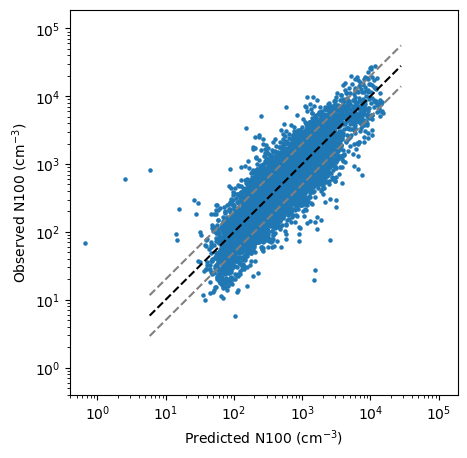

In [11]:
y_pred = regressor.predict(X_test)
rmse, r2, fraction = evaluate(np.exp(y_pred), np.exp(y_test))
print(f'RMSE: {rmse:.2f}, R2: {r2:.2f}, Fraction within factor two: {fraction:.2f}')
plot_results(np.exp(y_pred), np.exp(y_test))

In [12]:
params = {'n_estimators': [100], 'reg_lambda': [1, 2, 3], 'learning_rate': [0.1, 0.2 , 0.3], 'max_depth': [10]}

In [13]:
tuning = xgboost(X_train, y_train, params, tune=True)

In [14]:
params = tuning.best_params_
print(params)

{'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 100, 'reg_lambda': 3}


In [15]:
regressor = tuning.best_estimator_

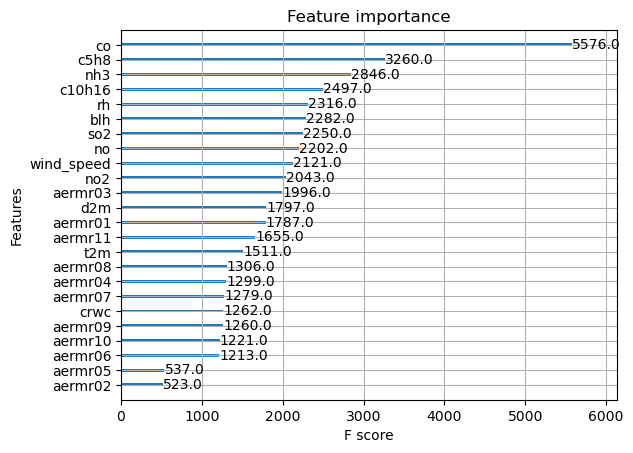

In [16]:
xgb.plot_importance(regressor)
plt.show()

RMSE: 667.10, R2: 0.82, Fraction within factor two: 0.92


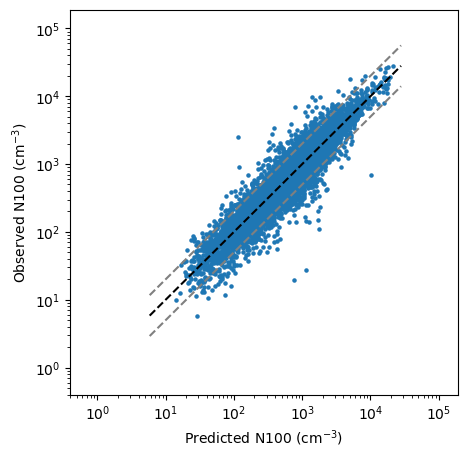

In [17]:
y_pred = regressor.predict(X_test)
rmse, r2, fraction = evaluate(np.exp(y_pred), np.exp(y_test))
print(f'RMSE: {rmse:.2f}, R2: {r2:.2f}, Fraction within factor two: {fraction:.2f}')
plot_results(np.exp(y_pred), np.exp(y_test))

In [18]:
lr_results = {}
xgboost_results = {}
for station in stations:
    # Select data
    data_train = data[data.station != station]
    data_test = data[data.station == station]
    X_train, y_train = data_train[features], data_train.n100
    X_test, y_test = data_test[features], data_test.n100
    
    # Train linear regression
    regressor = linear_regression(X_train, y_train)
    y_pred = regressor.predict(X_test)
    rmse, r2, fraction = evaluate(np.exp(y_pred), np.exp(y_test))
    lr_results[station] = {'rmse': rmse, 'r2': r2, 'fraction': fraction}
    
    # Train XGBoost
    regressor = xgboost(X_train, y_train, params)
    y_pred = regressor.predict(X_test)
    rmse, r2, fraction = evaluate(np.exp(y_pred), np.exp(y_test))
    xgboost_results[station] = {'rmse': rmse, 'r2': r2, 'fraction': fraction}

In [19]:
def plot_bar_comparison(lr_results, xgboost_results, metric):
    lr_keys = list(lr_results.keys())

    # Get the fraction values for each dictionary, in the same order as the keys
    lr_fractions = [lr_results[k][metric] for k in lr_keys]
    xgboost_fractions = [xgboost_results[k][metric] for k in lr_keys]
    
    fig = plt.figure(figsize=(18, 8))
    ax = fig.add_subplot()
    width = 0.3 # the width of the bars
    x = range(len(lr_keys)) # the x locations for the bars

    # Plot the bars for Linear Regression
    avg = np.mean(lr_fractions)
    std = np.std(lr_fractions)
    rects1 = ax.bar([i - width/2 for i in x], lr_fractions, width, label=f'Linear Regression, avg: {avg:.2f} ± {std:.2f}')

    # Plot the bars for XGBoost
    avg = np.mean(xgboost_fractions)
    std = np.std(xgboost_fractions)
    rects2 = ax.bar([i + width/2 for i in x], xgboost_fractions, width, label=f'XGBoost, avg: {avg:.2f} ± {std:.2f}')

    # Add some labels, etc.
    ax.set_ylabel('Fraction of predictions within 1:2 and 2:1', fontsize=15)
    ax.set_xticks(x)
    ax.set_xticklabels(lr_keys)
    ax.tick_params(labelsize=13)
    ax.set_ylim([0, 1])
    ax.set_xlim([-1, len(lr_keys)])
    ax.legend(prop={'size': 15})

    plt.show()

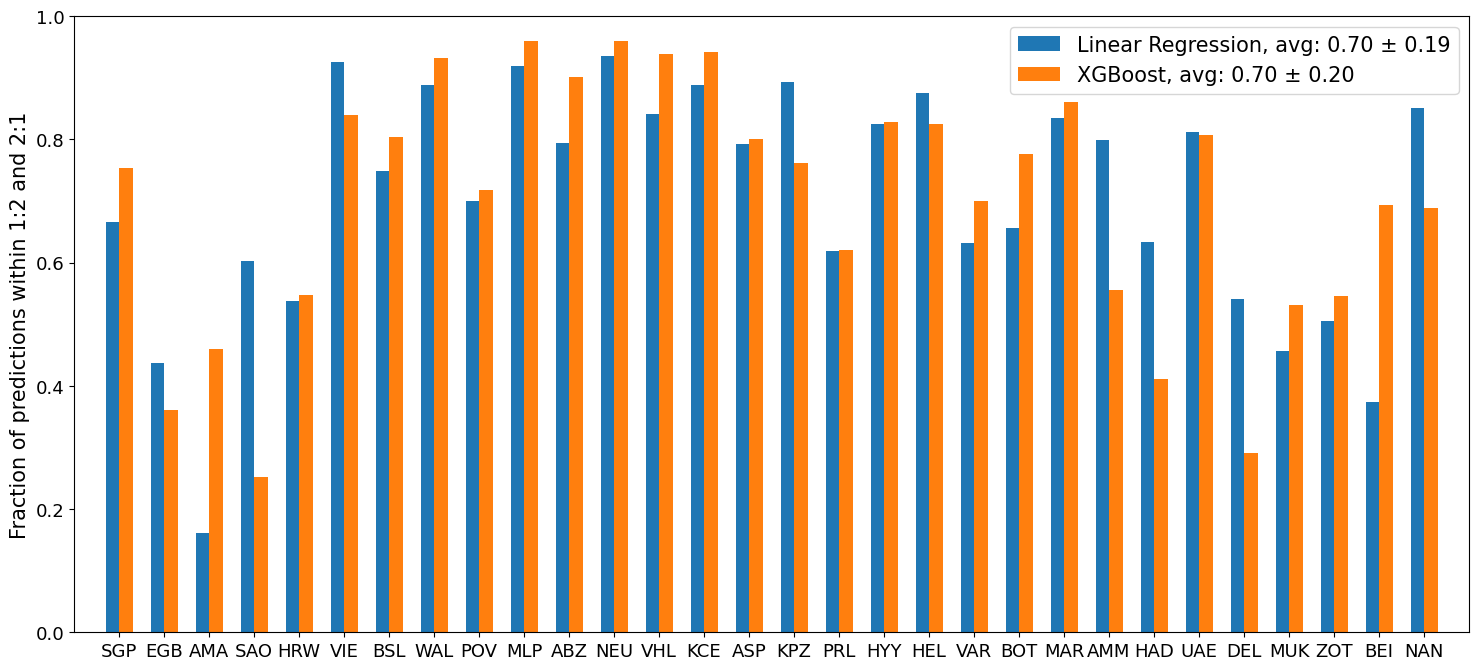

In [20]:
plot_bar_comparison(lr_results, xgboost_results, 'fraction')